In [162]:
import matplotlib.pyplot as plt
from random import choice
from log_reg_util import one_hot, one_cold, softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from math import exp, log
import numpy as np

In [163]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

## Exercises
### Building on Logistic Regression, implement one hidden layer with a sigmoid activation function. Remember the last layer of a neural network is just a logistic regression layer. Use the network on the [Digits](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) dataset.

In [164]:
from sklearn.datasets import load_digits

In [165]:
digits = load_digits()
data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

In [166]:
def plot_image(image, **kwargs):
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', **kwargs)
    None    

Digit:  0


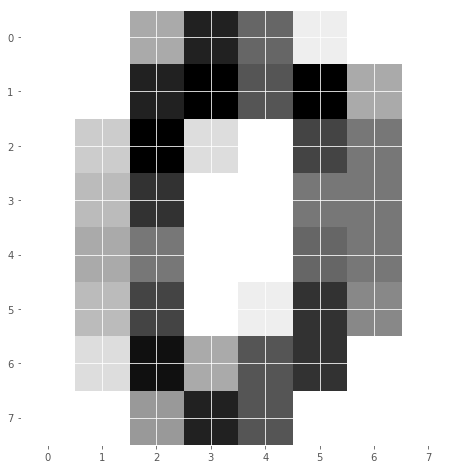

In [167]:
test_ix = choice(target)
test_image = images[test_ix]
test_target = target[test_ix]

print("Digit: ",test_target)
plot_image(test_image)

### Preprocess data using train test split, scaling and your one hot encoding function.

In [168]:
hot_target = np.array(one_hot(target, target_names))

In [169]:
X_train, X_test, y_train, y_test = map(np.array, train_test_split(data, hot_target))

### Implement the ‘sigmoid’ and its element-wise derivative ‘dsigmoid’ functions:

In [170]:
def sigmoid(val, threshold=0.5):
    """ Sigmoid function implementation """
    return 1/(1 + np.exp(-val))

def dsigmoid(val, threshold=0.5):
    """ Element-wise derivative of sigmoid function """
    sig = sigmoid(val, threshold)
    return sig * (1-sig)

### Plot both the sigmoid and its derivative and compare it to wikipedia or wolframalpha.

In [171]:
n = 1000
# x = np.log([i/n for i in range(1,n)]) + np.log([i for i in range(1,n)])
x = [i/n for i in range(1, n)] + [i for i in range(1, n)]

In [172]:
y_sig = [sigmoid(i) for i in x]
y_dsig = [dsigmoid(i) for i in x]

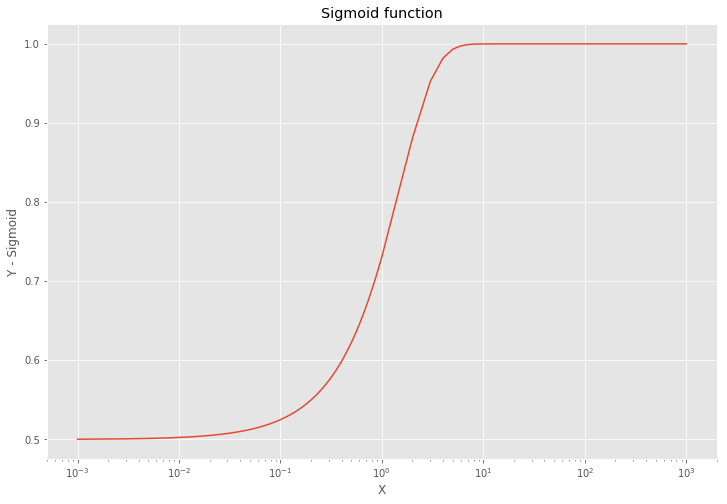

In [173]:
plt.plot(x, y_sig)
plt.title("Sigmoid function")
# plt.xlabel('X - log scale')
plt.xlabel('X')
plt.xscale('log')
plt.ylabel('Y - Sigmoid')
None

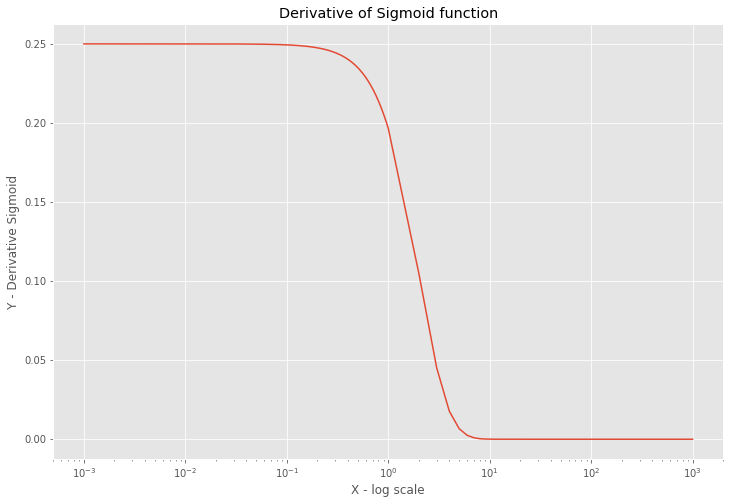

In [174]:
plt.plot(x, y_dsig)
plt.title("Derivative of Sigmoid function")
# plt.xlabel('X - log scale')
plt.xlabel('X - log scale')
plt.xscale('log')
plt.ylabel('Y - Derivative Sigmoid')
None

---

### Build training pipeline

In [175]:
def nll_alt(Y_true, Y_pred):
    EPSILON = 1e-10
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

In [176]:
def accuracy(y_true, y_hot):
    # Compute accuracy for samples X with true labels y
    y_preds = np.argmax(y_hot, axis=1)
    return np.mean(np.equal(y_preds, y_true))

In [177]:
def forward_pass(W_, x_, b_):
    return x_.dot(W_) + b_
#     return x_.dot(W_)

In [178]:
def forward_keep_activations(x_, Wh_, bh_, Wo_, bo_):
    z_h = forward_pass(Wh_, x_, bh_)
    h = np.apply_along_axis(sigmoid, 0, z_h)
    z_o = forward_pass(Wo_, h, bo_)
    y = np.apply_along_axis(softmax, 0, z_o)
    return y, h, z_h, z_o

In [179]:
def grad_loss(x_, y_hot, Wh_, bh_, Wo_, bo_):
    y, h, z_h, _ = forward_keep_activations(x_, Wh_, bh_, Wo_, bo_)
  
#     grad_z_o = (y - y_hot) * dsigmoid(y)
    grad_z_o = y - y_hot
    grad_W_o = np.outer(h, grad_z_o)
    grad_b_o = grad_z_o
    
    grad_h = np.dot(grad_z_o, np.transpose(Wo_))
    grad_z_h = grad_h * dsigmoid(z_h)
    grad_W_h = np.outer(x_, grad_z_h)
    grad_b_h = grad_z_h
       
    return grad_W_h, grad_b_h, grad_W_o, grad_b_o, nll_alt(y_hot, y)

In [180]:
def train(X_, y_hot, model = None, learning_rate = 0.005):
    input_size = X_.shape[1] 
    output_size = y_hot.shape[1]
    hidden_size = 20
    
    if model is None:
        W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
        b_h = np.zeros(hidden_size) 
        W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
        b_o = np.zeros(output_size)
    else:
        W_h, b_h, W_o, b_o = model
    
    losses = []
    for i, (x_, y_) in enumerate(zip(X_, y_hot)):
        grad_W_h, grad_b_h, grad_W_o, grad_b_o, loss = grad_loss(x_, y_, W_h, b_h, W_o, b_o)
        W_h = W_h - learning_rate * grad_W_h
        b_h = b_h - learning_rate * grad_b_h
        W_o = W_o - learning_rate * grad_W_o
        b_o = b_o - learning_rate * grad_b_o
        
        losses.append(loss)  
        
    return [W_h, b_h, W_o, b_o, np.mean(losses)]

In [181]:
# W_h, b_h, W_o, b_o = train(X_train, y_train)
# y = forward_keep_activations(X_test, W_h, b_h, W_o, b_o)[0]

In [182]:
def train_epochs(X_train_, X_test_, y_train_, y_test_, n_epochs, report_interval = None):

    training = None
    accuracies = []
    losses = []

    for i in range(n_epochs):
        
        report = True if (report_interval is not None and i % report_interval == 0) else False
        
        training = train(X_train_, y_train_, training)
        loss = training.pop(-1)
        predictions = forward_keep_activations(X_test_, *training)[0]
        acc = accuracy(one_cold(y_test_), predictions)
        accuracies.append(acc)
        losses.append(loss)

        if report:
            print("=========================================")
            print("Accuracy after training: \t{:.2f}%".format(100*(acc)))
            print("Average loss after training: \t{:.4e}".format(loss))

    predictions = forward_keep_activations(X_test_, *training)[0]
    
    return predictions, accuracies, losses

In [183]:
n_epochs = 35
train_test = X_train, X_test, y_train, y_test
predictions, accuracies, losses = train_epochs(*train_test, n_epochs, 5)

Accuracy after training: 	64.89%
Average loss after training: 	2.1435e+00
Accuracy after training: 	92.89%
Average loss after training: 	3.6484e-01
Accuracy after training: 	95.56%
Average loss after training: 	1.6964e-01
Accuracy after training: 	96.44%
Average loss after training: 	1.0783e-01
Accuracy after training: 	96.44%
Average loss after training: 	7.9840e-02
Accuracy after training: 	96.00%
Average loss after training: 	6.3462e-02
Accuracy after training: 	96.00%
Average loss after training: 	5.2952e-02


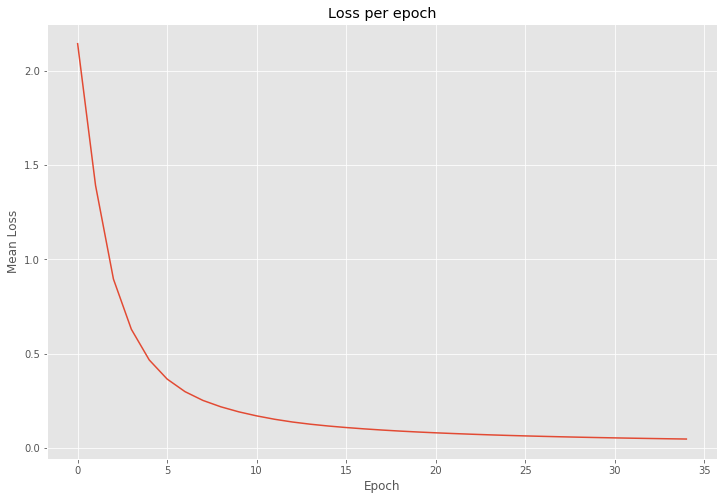

In [184]:
plt.plot(range(n_epochs), losses)
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss")
None

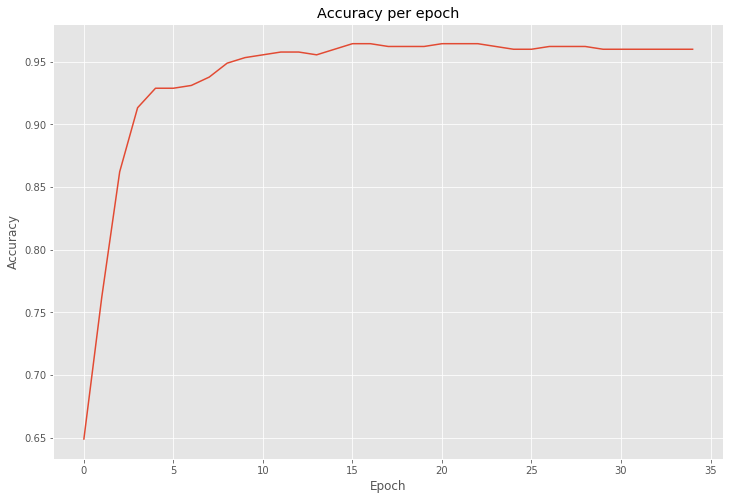

In [185]:
plt.plot(range(n_epochs), accuracies)
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
None

In [186]:
cold_true = one_cold(y_test)
cold_pred = one_cold(predictions)

conf = confusion_matrix(cold_true, cold_pred)

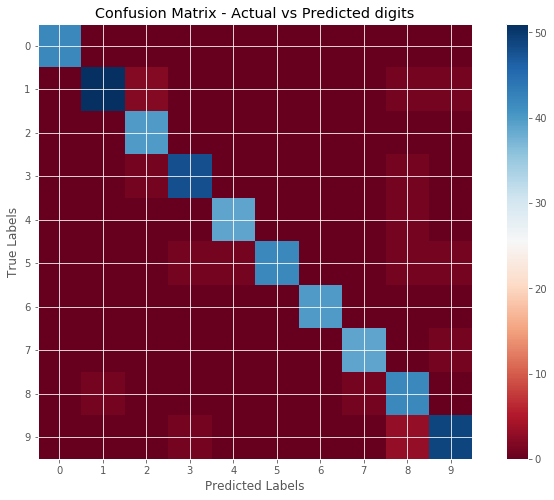

In [188]:
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.RdBu)
plt.colorbar()
tick_marks = target_names
plt.xticks(target_names, target_names)
plt.yticks(target_names, target_names)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix - Actual vs Predicted digits")
# TODO: add count of each digit in test set
None

---